In [3]:
import numpy as np
from plind.plmodel import plmodel
from plind.visualize import visualize_descent
from scipy.special import gamma
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

eps = np.finfo(float).eps

In [4]:
# Parameters
def expfun(x, y, a, b):
    return 1j*a*(b*(x-y)**2 - np.log(np.sqrt(x**2)))

start_time = 0.0
end_time = 0.3
Npts = 100
Nint = 1000
expargs = [0, 0.5, 2]

init_contour = np.append(np.exp(1j*0)*(1/np.tan(np.linspace(2*np.pi, 2.2*np.pi/2, Npts, endpoint=False)/2) + 0.0j),
                         np.exp(1j*0)*(1/np.tan(np.linspace(1.8*np.pi/2, -eps, Npts, endpoint=False)/2) + 0.0j))

In [5]:
plind = plmodel(init_contour, expfun, expargs=expargs)
plind.descend(start_time, end_time, term_frac_eval = 0.5, term_percent=0.05)

In [6]:
plind.solution.sget_message()

'The solver successfully reached the end of the integration interval.'

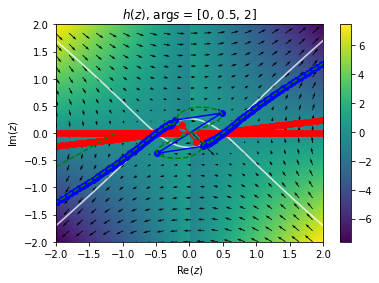

In [91]:
# Plot stuff
morsefun = plind.get_morse()
y, a, b = expargs
critpts = [0.5*(y + np.sqrt(y**2 + (2/b))), 0.5*(y - np.sqrt(y**2 + (2/b)))]
gradh = plind.get_grad()

domain = [-2, 2]
N = 100
U = np.linspace(domain[0], domain[1], N)
V = np.linspace(domain[0], domain[1], N)
U, V = np.meshgrid(U, V, indexing='ij')
Z = U + 1j*V

fig, ax = plt.subplots()
ax.set_title('$h(z)$, $\\args$ = {}'.format(expargs))
ax.set_xlabel("Re($z$)")
ax.set_ylabel("Im($z$)")
ax.set_ylim(domain[0], domain[1])
ax.set_xlim(domain[0], domain[1])
# Plot h
im = ax.pcolormesh(U, V, morsefun(Z, *expargs).real)
fig.colorbar(im, ax=ax)
for p0 in critpts:
        # Plot critical points
        ax.scatter(p0.real, p0.imag, color='w')
        # Plot contours of expfun.imag passing through p0, p1
        ax.contour(U, V, expfun(Z, *expargs).imag, [expfun(p0, *expargs).imag], colors='w', alpha=0.5)
        
trajectory = plind.get_trajectory()
line = plind.contour

for k in np.linspace(0, trajectory.shape[0], trajectory.shape[0]//10, endpoint=False):
    k = int(k)
    ax.plot(trajectory[k].real[1:-1], trajectory[k].imag[1:-1], 'ro-')

# Plot final contour and gradient
dn = 5
ax.quiver(U[::dn, ::dn], V[::dn, ::dn], gradh(Z[::dn, ::dn], *expargs).real, gradh(Z[::dn, ::dn], *expargs).imag, scale=140, color='k')
ax.plot(line.real[1:-1], line.imag[1:-1], 'bo-')

# Plot spline
contour_spline, contour_spline_der, contour_spline_param = plind.get_contour_spline()
splaram = np.linspace(contour_spline_param[0], contour_spline_param[-1], 5000)
xvals = contour_spline(splaram)
ax.plot(xvals.real, xvals.imag, '--', color='g')

plt.show()

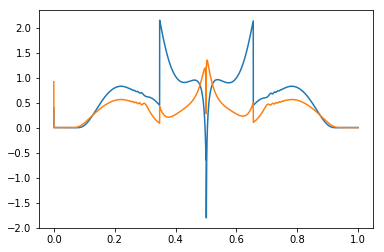

In [92]:
# Plot integrand along contour
intfun = plind.get_intfun()
intvals = intfun(xvals, *expargs)

fig, ax = plt.subplots()
ax.plot(splaram, intvals.real)
ax.plot(splaram, intvals.imag)

In [93]:
plind.integrate(Nint=1000)
print(plind.integral)

(1.7168698573915182+1.223991582197098j)


In [94]:
def answer(a, b):
    A = gamma(0.5 - 0.5*1j*a)*(a**2*b**2)**(-0.25*(1-1j*a))
    B = np.cosh(0.25*np.pi*(1j+a)) + 1j*np.cosh(0.25*np.pi*(-1j+a))*np.sign(a)*np.sign(b)
    return A*B

In [95]:
answer(0.5, 2)

(0.7455393913430943+2.155458633053102j)

In [96]:
# Try patching discontinuity

diffs = intvals - np.roll(intvals,1)
diffs_r = abs(diffs.real)
diffs_i = abs(diffs.imag)
inds_r = np.argsort(diffs_r)
inds_i = np.argsort(diffs_i)

locs = inds_r[-2:]
gap_r = diffs_r[locs[1]]
gap_i = diffs_i[locs[1]]

intgrd_r = np.array([intvals[i].real-gap_r if locs[1]-1<i<locs[0] else intvals[i].real for i in np.arange(len(intvals))])
intgrd_i = np.array([intvals[i].imag-gap_i if locs[1]-1<i<locs[0] else intvals[i].imag for i in np.arange(len(intvals))])
intgrd = (intgrd_r + 1j*intgrd_i)*contour_spline_der(splaram)
print(np.trapz(intgrd[1:], splaram[1:]))

(1.4178893531277401+2.716601591135135j)


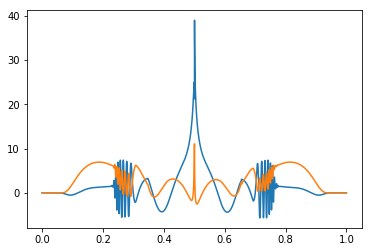

In [97]:
fig, ax = plt.subplots()
ax.plot(splaram[1:], intgrd[1:].real)
ax.plot(splaram[1:], intgrd[1:].imag)

In [79]:
locs[0]

655